In [1]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses02F_impro04_F012,2,or they ll never talk to me again .
1,Ses03F_script02_1_M030,4,for real ?
2,Ses02F_script03_2_M015,2,nothing .
3,Ses02F_script02_2_M025,2,you wanna get married again ?
4,Ses04M_script03_1_M021,1,let s savor the delight of the moment . come a...


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

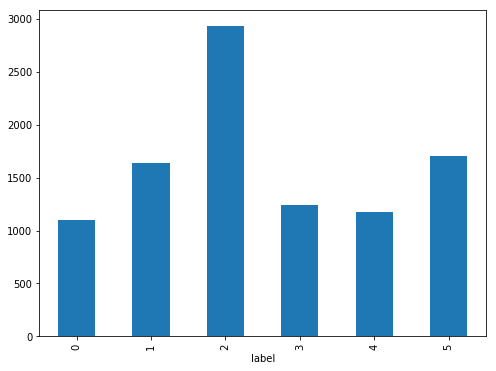

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.631
Test Set F-score =  0.630
Test Set Precision =  0.663
Test Set Recall =  0.631
Confusion matrix, without normalization
[[ 83  11  93  13   4  18]
 [  5 198  91  15   3  30]
 [ 32  28 402  39  10  63]
 [  0   0   0 258   0   0]
 [  0   2   0  39 174  11]
 [ 12  29 150  21   4 122]]


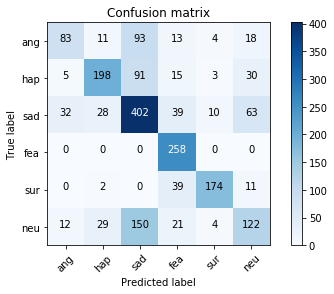

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.548
Test Set F-score =  0.540
Test Set Precision =  0.703
Test Set Recall =  0.503
Confusion matrix, without normalization
[[ 55  11 142   1   4   9]
 [  6 128 193   3   2  10]
 [ 18  23 501   5   3  24]
 [  0   0  66 192   0   0]
 [  3   2  93   0 128   0]
 [  4  20 236   5   2  71]]


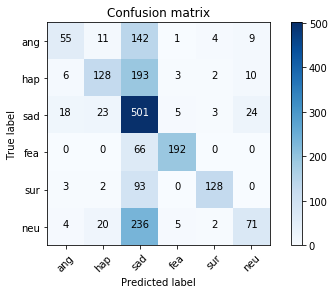

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.620
Test Set F-score =  0.641
Test Set Precision =  0.673
Test Set Recall =  0.620
Confusion matrix, without normalization
[[100   7  87   1   4  23]
 [  6 221  57   5   8  45]
 [ 42  40 381  11  11  89]
 [  0   0  59 199   0   0]
 [  0   2  38   1 174  11]
 [ 16  41 129   4   7 141]]


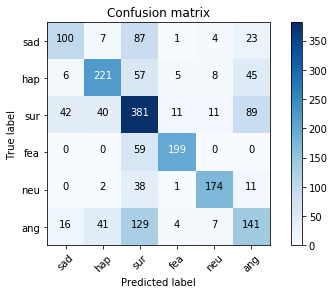

In [ ]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.605
Test Set F-score =  0.612
Test Set Precision =  0.706
Test Set Recall =  0.575
Confusion matrix, without normalization
[[ 79   8 110   2   6  17]
 [  2 191 106   5   6  32]
 [ 26  19 470   8   6  45]
 [  0   0  73 185   0   0]
 [  0   2  67   0 157   0]
 [  4  25 191   8   6 104]]


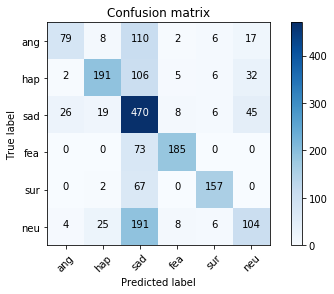

In [ ]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.635
Test Set F-score =  0.642
Test Set Precision =  0.641
Test Set Recall =  0.656
Confusion matrix, without normalization
[[105   6  68  11   7  25]
 [ 12 211  51  12  11  45]
 [ 49  36 338  36  16  99]
 [  0   0   0 258   0   0]
 [  0   0   0  39 187   0]
 [ 27  37 103  19   7 145]]


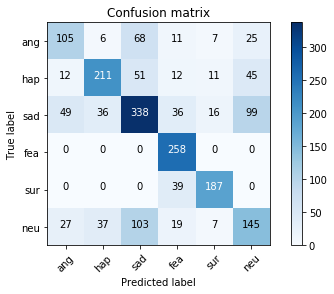

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.626
Test Set F-score =  0.636
Test Set Precision =  0.685
Test Set Recall =  0.611
Confusion matrix, without normalization
[[ 86   8 100   2   5  21]
 [  5 212  70   7   7  41]
 [ 30  30 428  11  10  65]
 [  0   0  59 199   0   0]
 [  0   5  38   1 171  11]
 [ 12  38 148   4   6 130]]


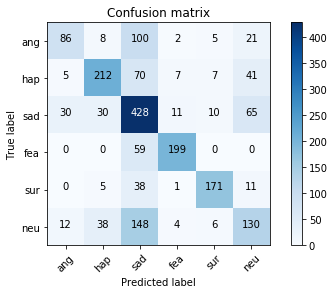

In [ ]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

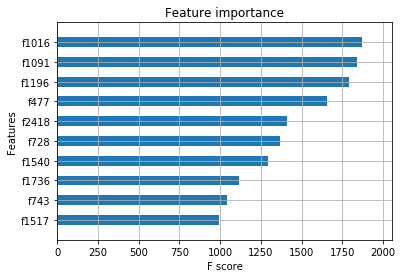

In [ ]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [ ]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00099294, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Test Set Accuracy =  0.190
Test Set F-score =  0.145
Test Set Precision =  0.149
Test Set Recall =  0.152
Confusion matrix, without normalization
[[ 20  29 102  30  26  15]
 [ 42  39 155  37  39  30]
 [ 82  73 236  53  79  51]
 [ 21  37 130  22  32  16]
 [ 31  27  95  19  33  21]
 [ 41  43 144  40  48  22]]


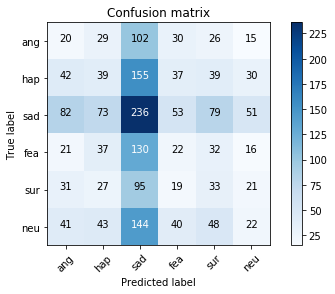

In [ ]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.631
Test Set F-score =  0.649
Test Set Precision =  0.702
Test Set Recall =  0.620
Confusion matrix, without normalization
[[ 96   7  96   1   4  18]
 [  6 207  81   4   5  39]
 [ 36  27 428   8   8  67]
 [  0   0  59 199   0   0]
 [  0   2  49   1 174   0]
 [ 11  34 151   4   5 133]]


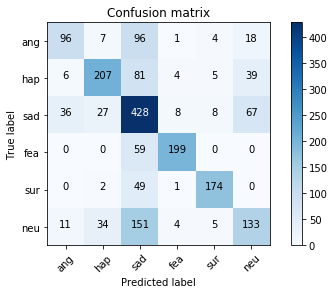

In [ ]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [ ]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:
Test Set Accuracy =  0.548
Test Set F-score =  0.540
Test Set Precision =  0.703
Test Set Recall =  0.503
Stats for top 1000 features:
Test Set Accuracy =  0.548
Test Set F-score =  0.540
Test Set Precision =  0.703
Test Set Recall =  0.503
Stats for top 1500 features:
Test Set Accuracy =  0.548
Test Set F-score =  0.540
Test Set Precision =  0.703
Test Set Recall =  0.503
Stats for top 2000 features:
